# Testing the codes when using multivariate Gaussian prior

This notebook provides tests of the `lalapps_pulsar_parameter_estimation_nested` code running normally and running using a Reduced Order Quadrature (ROQ) to calculate an approximation of the likelihood, against the `lalapps_pulsar_parameter_estimation` code, when both are run assuming a multi-variate Gaussian prior on various phase parameters. Here I run the code over a small range in frequency, frequency derivative and binary parameters.

To do the comparisons the code is run in its standard configuration and then run with the likelihood calculated using the ROQ approximations.

In [2]:
# import required modules

%matplotlib inline

from __future__ import print_function, division

import numpy as np
from scipy.signal import fftconvolve
import subprocess as sp
import os
import sys

sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

import gzip
import h5py
from time import time

from scotchcorner import scotchcorner

# these modules require lalapps
from lalapps.pulsarpputils import *
import lalpulsar

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

In [3]:
# define a function to work out how many effective (uncorrelated) samples the MCMC chains contain
def independent_samples(d):
    # get independent samples from the matrix d, where d contains an MCMC chain over a number of parameters.
    # The maximum autocorrelation length of all the parameter is used to define the number of effective samples.
    M = 5.
    K = 2.

    neff = []
    for par in d.T:
        x = par - np.mean(par)
        y = np.conj(x[::-1])
        z = fftconvolve(y, x, 'full')
        z = np.fft.ifftshift(z)
        acf = z[0:len(par)]
        acf = acf/acf[0]

        # estimate the autocorrelation length
        acf[1:] = acf[1:]*2.
        imax = int(len(acf)/K)
        cacf = np.cumsum(acf)
        s = np.arange(1, len(cacf)+1, dtype=np.float64)/float(M)
        idxs = np.flatnonzero(cacf[:imax] < s[:imax])
        if len(idxs) == 0:
            acl = 1
        else:
            acl = s[idxs[0]]
        neff.append(np.floor(len(par)/acl))

    minneff = int(np.min(neff))

    return d[np.random.permutation(d.shape[0])[0:minneff],:]

In [4]:
# set up the run directories
rundir = '.'
if not os.path.isdir(rundir): # make the directory
    os.makedirs(rundir)

detector = 'H1'        # the detector to use
psrname = 'J0000+0000' # a fake pulsar name

# set the output directory
outdir = os.path.join(rundir, 'output')
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# fake heterodyned data directory (for the lalapps_pulsar_parameter_estimation code
# this must be dataDET, where DET is e.g. H1)
datadir = os.path.join(rundir, 'data'+detector)
if not os.path.isdir(datadir): # make the directory
    os.makedirs(datadir)

# set the executables (this assumes that you are using virtual environments with virtualenvwrapper.sh and
# have a WORKON_HOME environment variable set, but you can change the path as required)
virenv = 'lalapps_knope_O2' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')
n2pexec = os.path.join(execpath, 'lalapps_nest2pos') # script to convert nested samples to posterior samples
ppeexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation')

## Running the codes

The code is run on random Gaussian noise with zero mean and a given standard deviation. The prior file adds frequency `F0` and first frequency derivative `F1` parameters and assumes Gaussian prior distributions on these.

I output a comparison plot between the posteriors produced with and without the ROQ. I compare the upper limits, evidences and maximum likelihoods produced by each method. I also compare the run times for each implementation of the code.

In [8]:
# set up some general inputs

# create a pulsar parameter (TEMPO-stype .par file) file format string
pardat = """PSRJ J0000+0000
RAJ {}
DECJ {}
F0 {}           1 {}
F1 {}           1 {}
PEPOCH 56789.0
EPHEM DE405
BINARY BT
PB {}           1 {}
T0 {}           1 {}
A1 {}           1 {}
OM {}           1 {}
ECC {}          1 {}
OMDOT {}        1 {}
"""

# create correlation coefficient matrix 
cordat = """F0 F1 PB T0 A1 OM ECC OMDOT
F0 1
F1 0 1
PB 0 0 1
T0 0 0 0 1
A1 0 0 0 0 1
OM 0 0 0 0.9999 0 1
ECC 0 0 0 0 0 0 1
OMDOT 0 0 0.9999 0 0 0 0 1
"""

# some defaults for the data generation
sigma = 1.0e-22        # set data standard deviation
dt = 60                # number of seconds between data points
gpsstart = 1125969920  # GPS start time of data (over a year after the pulsar period epoch)
duration = 86400      # duration of data (seconds) - 1 days
gpstimes = np.arange(gpsstart, gpsstart+duration, dt) # time stamps
dlen = len(gpstimes)   # length of data

# get an estimate of the 95% credible upper limit to be expected
ulest = 10.8*np.sqrt(sigma**2/dlen)

# create the prior file for the lalapps_pulsar_parameter_estimation_nested code
# the F0 and F1 parameters have Gaussian prior distributions
f0 = (27.38, 1e-7) # mean and standard deviation
f1 = (-1e-12, 1e-13)
PB = (0.52, 3e-9)   # days
T0 = (50000., 3e-5) # MJD
A1 = (4.0, 3e-5)    # light secs
OM = (123.4, 2e-2)  # degs
ECC = (5e-5, 1e-5)
OMDOT = (2.0, 1e-3) # deg/year

priorfile = os.path.join(rundir, 'pulsar.prior')
priordat = """H0 uniform 0 {}
PHI0 uniform 0 {}
PSI uniform 0 {}
COSIOTA uniform -1 1
F0 gaussian {:.7f} {:.1e}
F1 gaussian {:.1e} {:.1e}
PB gaussian {:.12e} {:.12e}
T0 gaussian {:.12e} {:.12e}
A1 gaussian {:.12e} {:.12e}
OM gaussian {:.12e} {:.12e}
ECC gaussian {:.12e} {:.12e}
OMDOT gaussian {:.12e} {:.12e}
"""

fp = open(priorfile, 'w')
# set the h0 upper range to be 6 times the expected upper limit 
fp.write(priordat.format(ulest*6., np.pi, np.pi/2., f0[0], f0[1], f1[0], f1[1], PB[0]*86400., PB[1]*86400.,
                         lalpulsar.TTMJDtoGPS(T0[0]), T0[1]*86400., A1[0], A1[1], OM[0]*np.pi/180., OM[1]*np.pi/180.,
                         ECC[0], ECC[1], OMDOT[0]*np.pi/(180.*365.25*86400.), OMDOT[1]*np.pi/(180.*365.25*86400.)))
fp.close()

# output correlation coefficient file
corfile = os.path.join(rundir, 'pulsar.cor')
fp = open(corfile, 'w')
fp.write(cordat)
fp.close()

# lalapps_pulsar_parameter_estimation_nested run parameters
Nlive = '2048' # number of nested sample live points

# ROQ setup
ntraining = '1500'     # the number of training models to form the reduced basis
roqtolerance = '5e-12' # the maximum allowed residuals between the training set and reduced basis
roqfile = os.path.join(datadir, 'roq.bin') # a file to output the ROQ intepolants and nodes

In [5]:
# create data
data = sigma*np.random.randn(dlen, 2)

# append times and data together
tad = np.vstack((gpstimes, data.T)).T

# output fake data
datafile = os.path.join(datadir, 'finehet_'+psrname+'_'+detector)
np.savetxt(datafile, tad, fmt='%.6f %.7e %.7e', delimiter='\t')
    
# set a sky position
rah, ram, ras = rad_to_hms(0.0)
decd, decm, decs = rad_to_dms(0.0)

# output .par file containing right ascension and declination
parfile = os.path.join(rundir, 'pulsar.par')
fp = open(parfile, 'w')
fp.write(pardat.format(coord_to_string(rah, ram, ras), coord_to_string(decd, decm, decs), f0[0], f0[1], f1[0], f1[1],
                       PB[0], PB[1], T0[0], T0[1], A1[0], A1[1], OM[0], OM[1], ECC[0], ECC[1], OMDOT[0], OMDOT[1]))
fp.close()

# run lalapps_pulsar_parameter_estimation using the ROQ (first run to generate the ROQ)
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outfile', os.path.join(outdir, 'fake_nest_roq.hdf'),
                     '--Nlive', Nlive, '--Nmcmcinitial', '0', '--roq', '--roq-tolerance',
                     roqtolerance, '--ntraining', ntraining, '--output-weights', roqfile, '--cor-file', corfile])

t0 = time()
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
t1 = time()
timegenerateroq = (t1-t0)

# run lalapps_pulsar_parameter_estimation using the ROQ (using pregenerated ROQ)
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outfile', os.path.join(outdir, 'fake_nest_roq.hdf'),
                     '--Nlive', Nlive, '--Nmcmcinitial', '0', '--roq',
                     '--input-weights', roqfile, '--cor-file', corfile])

t0 = time()
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
t1 = time()
timeroq = (t1-t0)

# nested samples need to be converted to posterior samples with lalapps_nest2pos
if os.path.isfile(os.path.join(outdir, 'fake_post_roq.hdf')):
    os.remove(os.path.join(outdir, 'fake_post_roq.hdf'))
codecall = ' '.join([n2pexec, '-p', os.path.join(outdir, 'fake_post_roq.hdf'),
                     os.path.join(outdir, 'fake_nest_roq.hdf')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

In [12]:
# run lalapps_pulsar_parameter_estimation in MCMC mode
iterations = '50000'
burnin = '50000'
sharepath = os.path.join(os.environ['WORKON_HOME'], virenv)
sharepath = os.path.join(sharepath, 'share/lalpulsar')
earthfile = os.path.join(sharepath, 'earth00-19-DE405.dat.gz')
sunfile = os.path.join(sharepath, 'sun00-19-DE405.dat.gz')
timefile = os.path.join(sharepath, 'te405_2000-2019.dat.gz')
codecall = ' '.join([ppeexec, '--detectors', detector,
                     '--pulsar', psrname, '--par-file', parfile, '--input-dir', rundir,
                     '--output-dir', outdir, '--mcmc', '--iterations', iterations,
                     '--burn-in', burnin, '--psi-bins', '1000', '--time-bins', '1440',
                     '--chunk-max', '1440', '--use-cov', '--earth-ephem', earthfile,
                     '--sun-ephem', sunfile, '--time-ephem', timefile])
print(codecall)
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/bin/lalapps_pulsar_parameter_estimation --detectors H1 --pulsar J0000+0000 --par-file ./pulsar.par --input-dir . --output-dir ./output --mcmc --iterations 50000 --burn-in 50000 --psi-bins 1000 --time-bins 1440 --chunk-max 1440 --use-cov --earth-ephem /home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/share/lalpulsar/earth00-19-DE405.dat.gz --sun-ephem /home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/share/lalpulsar/sun00-19-DE405.dat.gz --time-ephem /home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/share/lalpulsar/te405_2000-2019.dat.gz


In [6]:
postroq, evsigroq, evnoiseroq = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post_roq.hdf'))

asining SINI
Read columns ['A1', 'COSIOTA', 'ECC', 'F0', 'F1', 'H0', 'OM', 'OMDOT', 'PB', 'PHI0', 'PSI', 'T0', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'A1_2', 'A1_3', 'DTHETA', 'ECC_3', 'DR', 'A0', 'PSIVECTOR', 'DEC', 'B0', 'I21', 'HVECTORY', 'EPS2DOT', 'PB_3', 'HPLUS', 'I31', 'F0_FIXED', 'ECC_2', 'GAMMA', 'FREQNUM', 'MTOT', 'C21', 'HCROSS', 'PEPOCH', 'XPBDOT', 'df', 'EPS1', 'PBDOT', 'DIST', 'LAMBDA', 'PHI22', 'PHI21', 'F1_FIXED', 'OM_3', 'OM_2', 'PHI0TENSOR', 'RA', 'IOTA', 'HSCALARL', 'EPS1DOT', 'POSEPOCH', 'HSCALARB', 'XDOT', 'M2', 'PX', 'PB_2', 'PMRA', 'PMDEC', 'Q22', 'THETA', 'PSISCALAR', 'EDOT', 'EPS2', 'PHI0VECTOR', 'PSITENSOR', 'PHI0SCALAR', 'COSTHETA', 'TASC', 'CGW', 'T0_3', 'T0_2', 'HVECTORX', 'I']


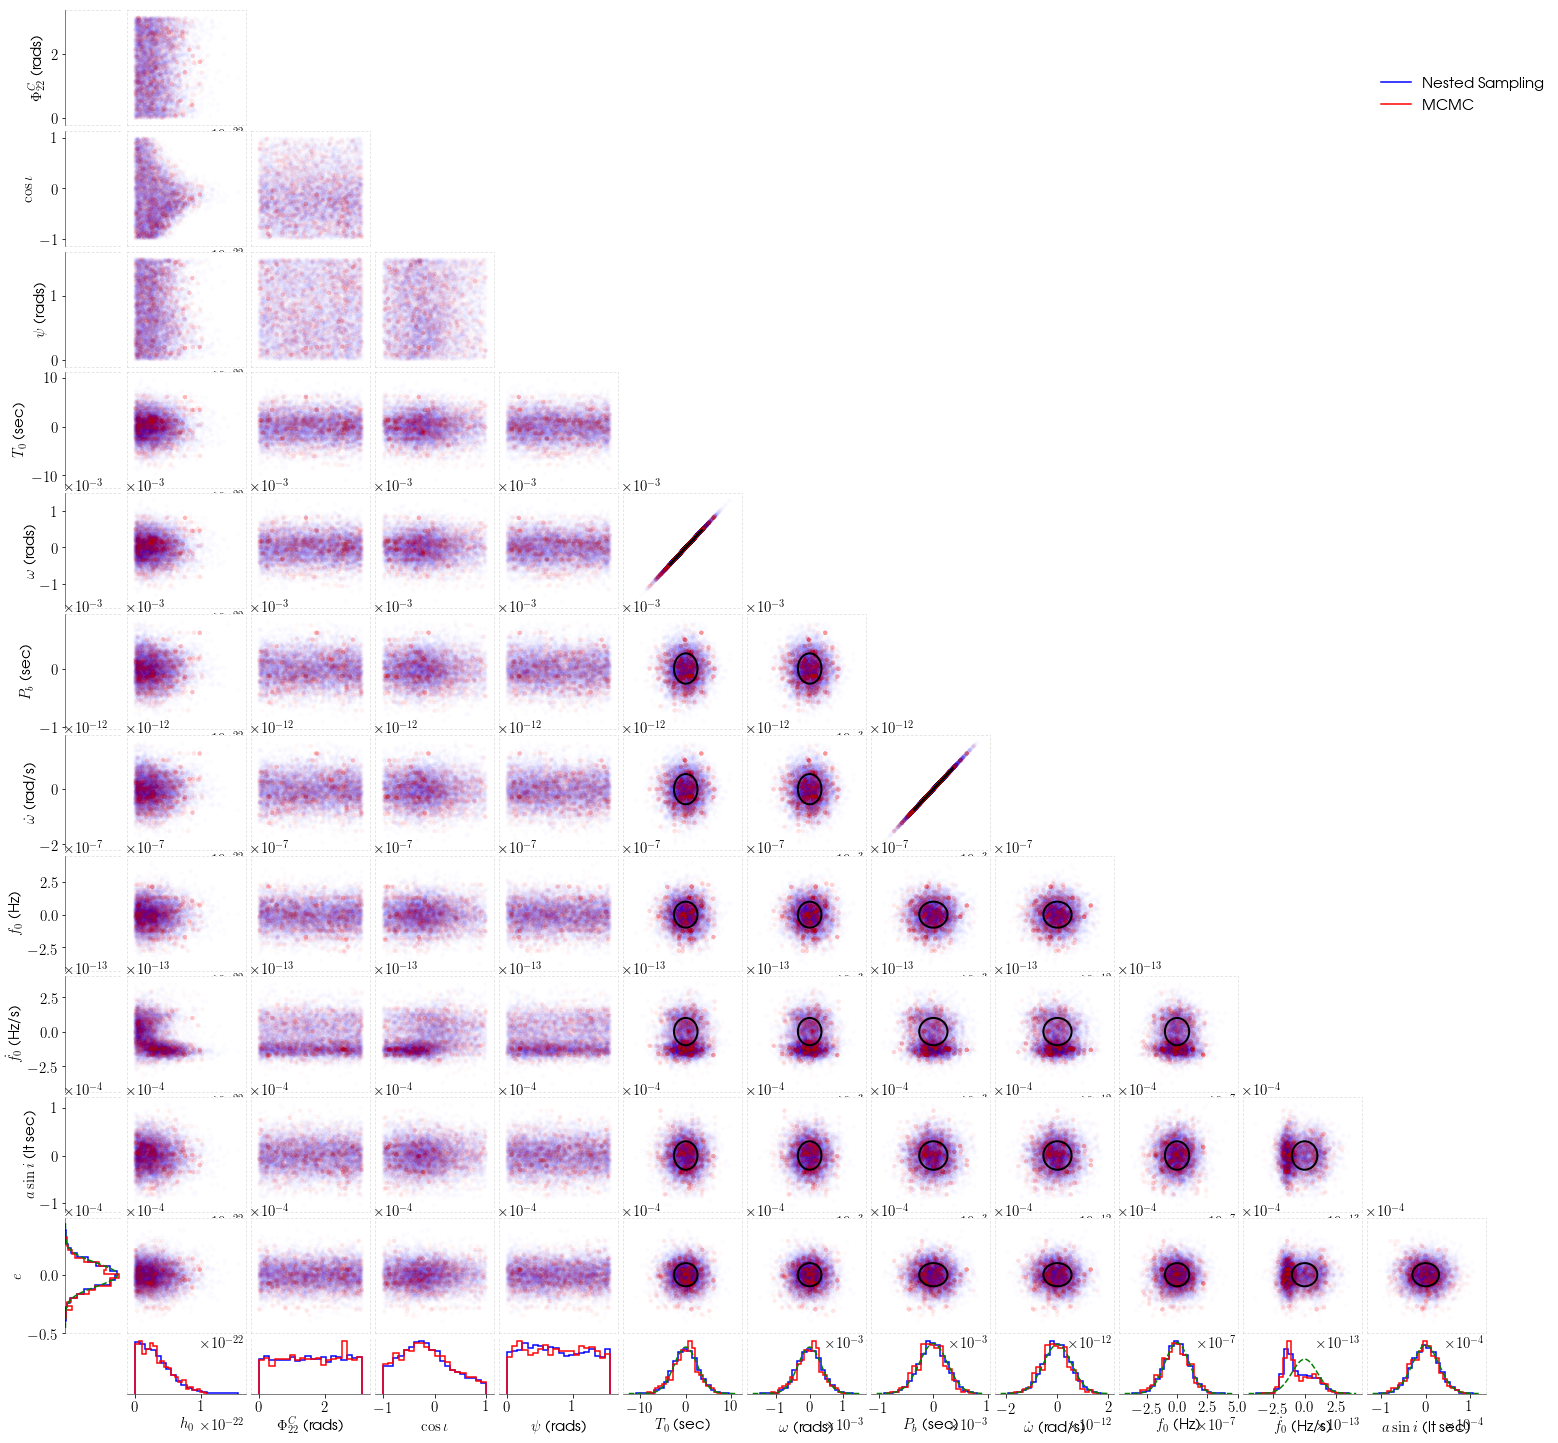

In [91]:
# load MCMC chains
postppemcmc = np.loadtxt(os.path.join(outdir, 'MCMCchain_%s_%s' % (psrname, detector)), comments='%')

# get independent MCMC samples
postmcmcind = independent_samples(postppemcmc[:,1:])
postmcmc = postppemcmc[::10,1:]
#print("Number of independent MCMC samples is %d from %s" % (postmcmcind.shape[0], postppemcmc.shape[0]))

# move psi into the 0 -> pi/2 range
psiidx = postmcmcind[:,3] < 0
postmcmcind[psiidx,3] = postmcmcind[psiidx,3] + np.pi/2.
# shift associated GW phases by pi
postmcmcind[psiidx,1] = np.fmod(postmcmcind[psiidx,1] + np.pi, 2.*np.pi)
postmcmcind[:,1] = postmcmcind[:,1]/2. # convert to rotational phase

psiidx = postmcmc[:,3] < 0
postmcmc[psiidx,3] = postmcmc[psiidx,3] + np.pi/2.
# shift associated GW phases by pi
postmcmc[psiidx,1] = np.fmod(postmcmc[psiidx,1] + np.pi, 2.*np.pi)
postmcmc[:,1] = postmcmc[:,1]/2. # convert to rotational phase

# get required parameter columns
params = ['h0', 'phi0', 'cosiota', 'psi', 't0', 'om', 'pb', 'omdot','f0', 'f1', 'a1', 'ecc']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppenroq = np.zeros((len(postroq['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppenroq[:,i] = postroq[p].samples[:,0]

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = ['$h_0$', '$\Phi_{22}^C$ (rads)', '$\cos{\iota}$', '$\psi$ (rads)', '$T_0$ (sec)', '$\omega$ (rads)',
          '$P_b$ (sec)','$\dot{\omega}$ (rad/s)', '$f_0$ (Hz)', '$\dot{f}_0$ (Hz/s)', '$a\sin{i}$ (lt sec)', '$e$']
limits = [(0., None), (0., np.pi), (-1., 1.), (0., np.pi/2.), (None, None), (None, None),
          (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]

# subtract means from f0 and f1
postppenroq[:,params.index('f0')] = postppenroq[:,params.index('f0')] - f0[0]
postppenroq[:,params.index('f1')] = postppenroq[:,params.index('f1')] - f1[0]
postppenroq[:,params.index('a1')] = postppenroq[:,params.index('a1')] - A1[0]
postppenroq[:,params.index('ecc')] = postppenroq[:,params.index('ecc')] - ECC[0]
postppenroq[:,params.index('t0')] = postppenroq[:,params.index('t0')] - lalpulsar.TTMJDtoGPS(T0[0])
postppenroq[:,params.index('pb')] = postppenroq[:,params.index('pb')] - PB[0]*86400.
postppenroq[:,params.index('om')] = postppenroq[:,params.index('om')] - OM[0]*np.pi/180.
postppenroq[:,params.index('omdot')] = postppenroq[:,params.index('omdot')] - OMDOT[0]*(np.pi/180.)/(365.25*86400.)

# get K-S tests of MCMC and NS distributions
KSpvals = {}
from scipy.stats import ks_2samp
for i, p in enumerate(params):
    D, KSpvals[p] = ks_2samp(postppenroq[:,params.index(p)], postmcmcind[:,i])

# add the standard run
sc = scotchcorner(postppenroq, bins=20, ratio=2, labels=labels, datatitle='Nested Sampling', showlims='both', hist_kwargs=histops,
                  showcontours=False, limits=limits, showpoints=True, scatter_kwargs={'alpha': 0.01})
# add the MCMC run
histops = {'histtype': 'step', 'color': 'r', 'linewidth': 1.5}
sc.add_data(postmcmc, hist_kwargs=histops, datatitle='MCMC', showcontours=False, scatter_kwargs={'alpha': 0.01}, limits=limits)

# add F0 and F1 prior distributions
from scipy.stats import norm
for l, v in zip(['$T_0$ (sec)', '$\omega$ (rads)','$P_b$ (sec)','$\dot{\omega}$ (rad/s)', '$f_0$ (Hz)', '$\dot{f}_0$ (Hz/s)', '$a\sin{i}$ (lt sec)', '$e$'], [86400.*T0[1], OM[1]*np.pi/180., PB[1]*86400., OMDOT[1]*(np.pi/180.)/(365.25*86400.), f0[1], f1[1], A1[1], ECC[1]]):
    thisax = sc.get_axis(l)
    if l == '$e$':
        thisrange = np.linspace(thisax.get_ylim()[0], thisax.get_ylim()[1], 100)
        thisax.plot(norm.pdf(thisrange, 0., v), thisrange, 'g--', lw=1.5)
    else:
        thisrange = np.linspace(thisax.get_xlim()[0], thisax.get_xlim()[1], 100)
        thisax.plot(thisrange, norm.pdf(thisrange, 0., v), 'g--', lw=1.5)
    
# draw on 2d ellipses
from matplotlib.patches import Ellipse
stds = [86400.*T0[1], OM[1]*np.pi/180., PB[1]*86400., OMDOT[1]*(np.pi/180.)/(365.25*86400.), f0[1], f1[1], A1[1], ECC[1]]
for i, v in enumerate(['$T_0$ (sec)', '$\omega$ (rads)','$P_b$ (sec)','$\dot{\omega}$ (rad/s)', '$f_0$ (Hz)', '$\dot{f}_0$ (Hz/s)', '$a\sin{i}$ (lt sec)', '$e$']):
    for j, v2 in enumerate(['$T_0$ (sec)', '$\omega$ (rads)','$P_b$ (sec)','$\dot{\omega}$ (rad/s)', '$f_0$ (Hz)', '$\dot{f}_0$ (Hz/s)', '$a\sin{i}$ (lt sec)', '$e$']):
        if i < j:
            pv = v+'vs'+v2
            thisax = sc.get_axis(v+'vs'+v2)
            if ('$P_b$ (sec)' in pv and '$\dot{\omega}$ (rad/s)' in pv) or ('$\omega$ (rads)' in pv and '$T_0$ (sec)' in pv):
                corcoeffmat = np.array([[1., 0.9999],[0.9999, 1.]])
            else:
                corcoeffmat = np.array([[1., 0.0],[0.0, 1.]])
            
            stdvals = np.array([stds[i], stds[j]])
            lam, ev = np.linalg.eig(corcoeffmat)
            lam = np.sqrt(lam)*stdvals

            ell = Ellipse(xy=(0.,0.), width=lam[0]*2., height=lam[1]*2., angle=np.rad2deg(np.arctan2(ev[1,0]*stdvals[1], ev[0,0]*stdvals[0])))
            ell.set_facecolor('none')
            ell.set_edgecolor('black')
            ell.set_linewidth(2)
            thisax.add_artist(ell)
